On March 1st 2021, Mayor Lori Lightfoot lowered the threshold for speeding tickets from 10 mph over the limit to 6. This policy is primarily enforced by the 153 speed cameras set up around Chicago. 

My motivation for performing this analysis is 



In [2]:
#import packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime
import sklearn as sk

### Data Load

In [3]:
crash = pd.read_csv('Traffic_Crashes_Crashes.csv')

In [4]:
violations = pd.read_csv('Speed_Camera_Violations.csv')

In [5]:
cameras = pd.read_csv('Speed_Camera_Locations.csv')

### Data Cleaning

In [6]:
#Formating camera address to be grouped by their respective Chicago city block
cameras['ADDRESS'] = [re.sub("\(Speed Camera\)","",addr).strip().upper() for addr in cameras['ADDRESS']]
cameras['STREET_NO'] = [re.findall("\d+",street_no)[0] for street_no in cameras['ADDRESS']]
cameras['BLOCK_NO'] = round(cameras['STREET_NO'].astype(int)/100)*100
cameras = cameras.astype({"BLOCK_NO":int})
cameras['FULL_ADDR'] = [re.sub(street_no,block_no,address) for street_no, block_no, address 
                        in zip(cameras['STREET_NO'],cameras['BLOCK_NO'].astype(str),cameras['ADDRESS'])]

In [7]:
#Remove crashes without reported streets
crash.dropna(subset=["STREET_NAME"],inplace=True)

#Formatting location of crash address to be grouped by their respective Chicago city block
crash['STREET_NO'] = crash['STREET_NO'].astype({"STREET_NO":int})
crash['BLOCK_NO'] = round(crash['STREET_NO']/100)*100
crash = crash.astype({"BLOCK_NO":int})
crash['FULL_ADDR'] = crash['BLOCK_NO'].astype(str) +" "+ crash['STREET_DIRECTION'] +" "+ crash['STREET_NAME'] 

#Format date to date format and adding a column to allow for date to be grouped by month
crash['CRASH_DATE'] = pd.to_datetime(crash['CRASH_DATE'],format="%m/%d/%Y %I:%M:%S %p").dt.date
crash['CRASH_DATE_TRUNC'] = crash['CRASH_DATE'].apply(lambda s: datetime.date(s.year, s.month, 1))

violations['VIOLATION DATE'] = pd.to_datetime(violations['VIOLATION DATE'],format="%m/%d/%Y").dt.date
violations['VIOLATION DATE TRUNC'] = violations['VIOLATION DATE'].apply(lambda s: datetime.date(s.year, s.month, 1))


In [8]:
#Dropping crashes that occurred prior to 9/1/17 because entire city did not start reporting on crashes until this date.
#datetime_str = '09/01/2017'
#datetime_object = datetime.datetime.strptime(datetime_str, '%m/%d/%Y')

crash = crash[(crash['CRASH_DATE_TRUNC']>datetime.date(2017,9,1))&(crash['CRASH_DATE_TRUNC']<datetime.date(2023,1,1))]
violations = violations[(violations['VIOLATION DATE']>datetime.date(2017,9,1))&(violations['VIOLATION DATE']<datetime.date(2023,1,1))]

In [33]:
#filter crash locations by speed camera block location plus adjacent streets.
cameras['BLOCK_NO_UP'] = cameras['BLOCK_NO'] +100
cameras['BLOCK_NO_DOWN'] = cameras['BLOCK_NO'] -100

In [34]:
cameras.loc[cameras[cameras['BLOCK_NO_DOWN']<0].index,'BLOCK_NO_DOWN'] = 0

In [35]:
cameras['FULL_ADDR_UP'] = [re.sub(street_no,block_no,address) for street_no, block_no, address 
                        in zip(cameras['STREET_NO'],cameras['BLOCK_NO_UP'].astype(str),cameras['ADDRESS'])]
cameras['FULL_ADDR_DOWN'] = [re.sub(street_no,block_no,address) for street_no, block_no, address 
                        in zip(cameras['STREET_NO'],cameras['BLOCK_NO_DOWN'].astype(str),cameras['ADDRESS'])]

In [36]:
camera_area = pd.concat([cameras['FULL_ADDR'],cameras['FULL_ADDR_UP'],cameras['FULL_ADDR_DOWN']]).unique()

In [37]:
camera_crash = crash[crash['FULL_ADDR'].isin(camera_area)]
no_camera_crash = crash[~crash['FULL_ADDR'].isin(camera_area)]

In [53]:
#Group by month truncated date and sum number of occurences
crash_group = crash[['CRASH_DATE_TRUNC','CRASH_RECORD_ID']].groupby(by='CRASH_DATE_TRUNC').count()
violation_group = violations[['VIOLATION DATE TRUNC','VIOLATIONS']].groupby(by='VIOLATION DATE TRUNC').sum()
camera_crash_group = camera_crash[['CRASH_DATE_TRUNC','CRASH_RECORD_ID']].groupby(by='CRASH_DATE_TRUNC').count()
no_camera_crash_group = no_camera_crash[['CRASH_DATE_TRUNC','CRASH_RECORD_ID']].groupby(by='CRASH_DATE_TRUNC').count()

In [54]:
camera_crash_data = camera_crash[['CRASH_DATE','CRASH_RECORD_ID']].groupby(by='CRASH_DATE').count()
no_camera_crash_data = no_camera_crash[['CRASH_DATE','CRASH_RECORD_ID']].groupby(by='CRASH_DATE').count()

In [67]:
#Need to bootstrap control group. Sample size 323, 1000 samples
len(no_camera_crash['FULL_ADDR'].unique())

32327

In [71]:
len(camera_crash['FULL_ADDR'].unique())

323

In [70]:
len(camera_area)

341

In [69]:
camera_crash['FULL_ADDR'].sample(10)

487985       4900 S WESTERN AVE
230072        400 S CENTRAL AVE
76709         5400 S PULASKI RD
561029     1400 W GARFIELD BLVD
383528       4700 W BELMONT AVE
601974        5400 S PULASKI RD
50416         5600 S KEDZIE AVE
41452          2800 W OGDEN AVE
684131    5600 W IRVING PARK RD
456213        4800 S ARCHER AVE
Name: FULL_ADDR, dtype: object

### Data Exploration

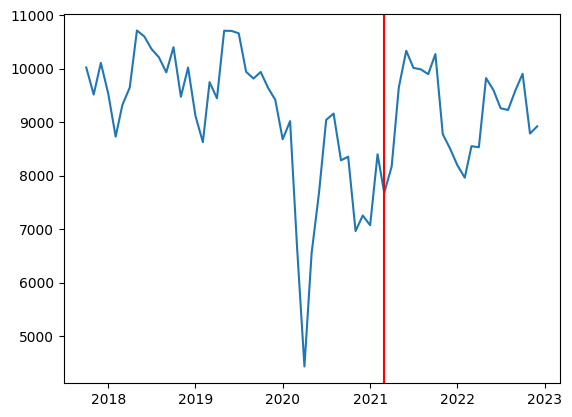

In [55]:
fig, ax = plt.subplots()
ax.plot(crash_group.index, crash_group['CRASH_RECORD_ID'])
plt.axvline(datetime.datetime(2021, 3, 1), color='r')

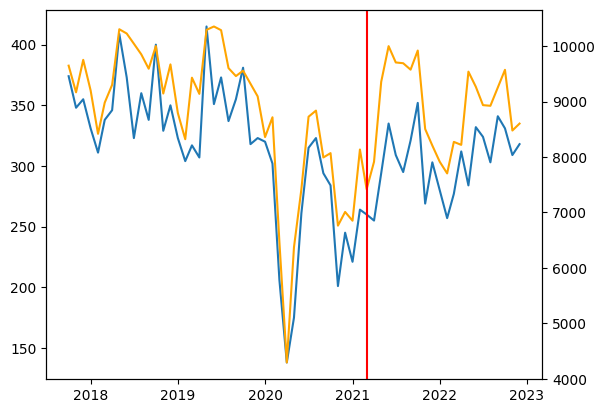

In [56]:
fig, ax = plt.subplots()
ax.plot(camera_crash_group.index, camera_crash_group['CRASH_RECORD_ID'])
ax2 = ax.twinx()
ax2.plot(no_camera_crash_group.index, no_camera_crash_group['CRASH_RECORD_ID'], color="orange")
plt.axvline(datetime.datetime(2021, 3, 1), color='r')

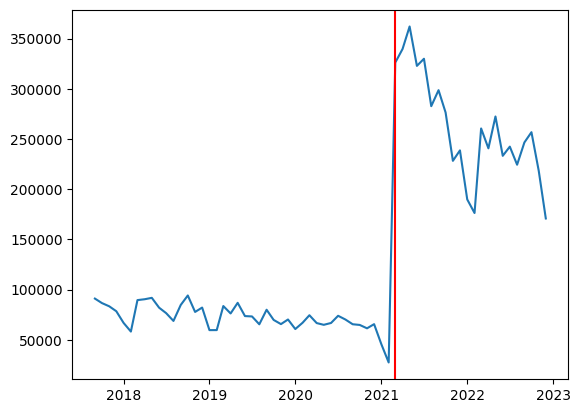

In [39]:
fig, ax = plt.subplots()
ax.plot(violation_group.index, violation_group['VIOLATIONS'])
plt.axvline(datetime.datetime(2021, 3, 1), color='r')

### Data Cleaning

In [40]:
#Filter crashes to only locations by speed camera


### Analysis

In [41]:
#Did adding a speed limit camera lower to the street also lower the number of crashes on the road?
#Did lowering speed limit threshold lower the number of crashes? How about the number of fatal crashes?
#Start with basic t-Test
#Try ARIMA 

### Conclusion